In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py

In [2]:
from sklearn import metrics

In [3]:
from tensorflow import keras

In [4]:
import sys

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
sys.path.append('../')

In [7]:
import datatools

In [8]:
import importlib

In [9]:
from glob import glob

## Load Data

In [10]:
SIM="/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation/"
DATA_LOC=f"{SIM}/stgc/atlas_nsw_pad_z0_stgc20Max1_bkgr_1_CovAngle_TRAIN/*.h5"

files=glob(DATA_LOC)

print(len(files))

135


In [11]:
data, dmat, Y, Y_mu, Y_hit, sig_keys = datatools.make_data_matrix(files, max_files=500, sort_by='z')

~~ Reading data... ~~


100%|██████████| 135/135 [00:08<00:00, 16.57it/s]


~~ Calculating occupancy information... ~~


100%|██████████| 387000/387000 [00:15<00:00, 24878.37it/s]

!!
I read 387000 events, of which 192000 have muon and 195000 do not
!!


In [12]:
data.keys()

dict_keys(['ev_mu_phi', 'ev_mu_theta', 'ev_mu_time', 'ev_mu_x', 'ev_mu_y', 'ev_n_mu_signals', 'ev_n_signals', 'n_sig_mmx', 'n_sig_mmu', 'n_sig_mmv', 'n_sig_mm', 'n_sig_stgc', 'n_sig_mdt'])

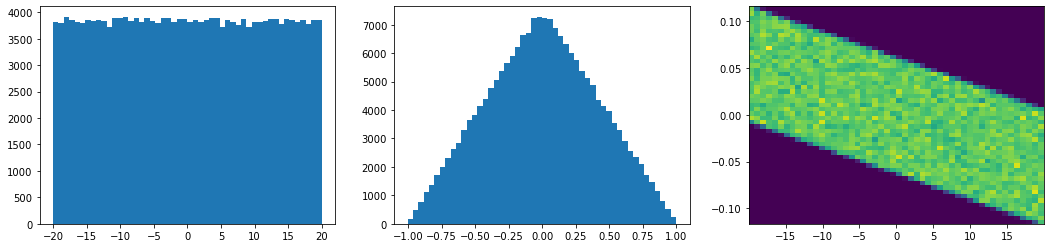

In [13]:
ncols, nrows = (3,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
axs = axs.flatten()
axs[0].hist(data['ev_mu_x'][Y_mu==1], bins=50)
axs[1].hist(data['ev_mu_theta'][Y_mu==1]/np.max(data['ev_mu_theta'][Y_mu==1]), bins=50)
axs[2].hist2d(data['ev_mu_x'][Y_mu==1], data['ev_mu_theta'][Y_mu==1], bins=(50,50))
plt.show()

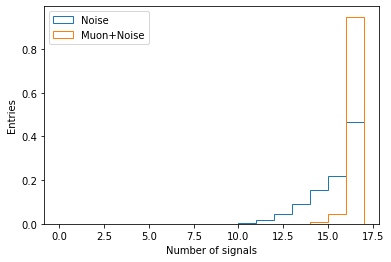

In [14]:
plt.Figure()
plt.hist(data['ev_n_signals'][Y_mu==0], density=1, histtype='step', range=(0,17), bins=17, label='Noise')
plt.hist(data['ev_n_signals'][Y_mu==1], density=1, histtype='step', range=(0,17), bins=17, label='Muon+Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of signals')
plt.ylabel('Entries')
plt.show()

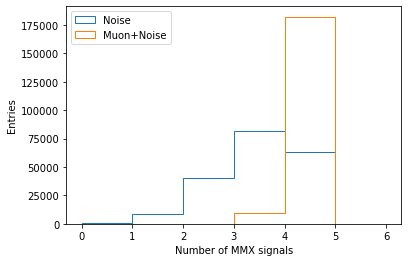

In [15]:
plt.Figure()
h_noise = plt.hist(data['n_sig_mmx'][Y_mu==0], histtype='step', range=(0,6), bins=6, label='Noise')
h_muons = plt.hist(data['n_sig_mmx'][Y_mu==1], histtype='step', range=(0,6), bins=6, label='Muon+Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of MMX signals')
plt.ylabel('Entries')
plt.show()

## Define models to compare

In [51]:
%ls -lhrt ../models/

total 1.5M
drwxr-sr-x 4 rafaeltl at 4.0K Jul 27 11:37 tcn_BatchNormFalse_MaskingFalse_regression1_27072022_11.24.20_normalMatrix/
drwxr-sr-x 4 rafaeltl at 4.0K Jul 28 01:47 tcn_BatchNormFalse_MaskingFalse_regression1_28072022_01.46.32_normalMatrix/
drwxr-sr-x 4 rafaeltl at 4.0K Jul 28 02:46 tcn_BatchNormFalse_MaskingFalse_regression1_28072022_02.33.52_normalMatrix/
drwxr-sr-x 4 rafaeltl at 4.0K Jul 28 04:56 tcn_BatchNormFalse_MaskingFalse_regression1_28072022_04.31.58_normalMatrix/
drwxr-sr-x 4 rafaeltl at 8.0K Aug  2 05:55 tcn_BatchNormFalse_MaskingFalse_regression1_02082022_05.55.22_normalMatrix/
drwxr-sr-x 4 rafaeltl at 4.0K Aug  2 05:58 tcn_BatchNormFalse_MaskingFalse_regression1_02082022_05.58.08_normalMatrix/
drwxr-sr-x 4 rafaeltl at 4.0K Aug  2 06:17 tcn_BatchNormFalse_MaskingFalse_regression1_02082022_06.03.45_normalMatrix/
drwxr-sr-x 4 rafaeltl at 4.0K Aug  2 08:27 tcn_BatchNormFalse_MaskingFalse_regression1_02082022_08.14.44_normalMatrix/
drwxr-sr-x 4 rafaeltl at 4.0K Aug  2 

In [52]:
import glob

In [113]:
allmodels = glob.glob("../models/MyTCN_*")

In [20]:
import trainingvariables

In [21]:
X_pad = datatools.training_prep(dmat, sig_keys)

~~ Preparing padded matrix ~~


100%|██████████| 387000/387000 [00:28<00:00, 13820.29it/s]

Output data matrix shape: (387000, 20, 19)


In [114]:
mdicts = []
for mloc in allmodels:
    if 'MyTCN_64,3,1:10,3,1_' not in mloc: 
        continue
    if mloc+'/history.npy' not in glob.glob(mloc+'/*'): 
        print(glob.glob(mloc+'/*'))
        continue
    
    print(mloc)
    mdict = {}
    mdict['name'] = mloc

    X_prep = X_pad
            
    vars_of_interest = np.zeros(X_prep.shape[2], dtype=bool)
    training_vars = trainingvariables.tvars
    for tv in training_vars:
        vars_of_interest[sig_keys.index(tv)] = 1
    # mdict['x'] = X_prep[:,:,vars_of_interest]
    # mdict['x_keys'] = np.array(sig_keys)[vars_of_interest]
    
    model_loc = '../models/'
    
    model = keras.models.load_model(mloc,compile=False)
    
    preds = model.predict(X_prep[:,:,vars_of_interest], batch_size=1024)
    
    mdict['yhat'] = preds[:,0]
    
    mult_fact = max(data['ev_mu_x'])
    mult_facta = max(data['ev_mu_theta'])
    
    mdict['x_reg'] = preds[:,1]*mult_fact
    mdict['a_reg'] = preds[:,2]*mult_facta
    
    mdict['n_params'] = model.count_params()
    
    mdicts.append(mdict)

../models/MyTCN_64,3,1:10,3,1_10:5_CBNormFalse_DBNormFalse_ll1_ptype2_penXTrue_penAFalse_bkgPenTrue_regBiasTrue
../models/MyTCN_64,3,1:10,3,1_5_CBNormFalse_DBNormFalse_ll1_ptype0_penXFalse_penATrue_bkgPenFalse_regBiasTrue
../models/MyTCN_64,3,1:10,3,1_10:5_CBNormFalse_DBNormFalse_ll1_ptype1_penXFalse_penATrue_bkgPenTrue_regBiasFalse
../models/MyTCN_64,3,1:10,3,1_20:10_CBNormFalse_DBNormFalse_ll1_ptype1_penXTrue_penATrue_bkgPenTrue_regBiasTrue
../models/MyTCN_64,3,1:10,3,1_20:10_CBNormFalse_DBNormFalse_ll1_ptype1_penXTrue_penATrue_bkgPenFalse_regBiasFalse
['../models/MyTCN_64,3,1:10,3,1_5_CBNormFalse_DBNormFalse_ll1_ptype1_penXTrue_penAFalse_bkgPenTrue_regBiasFalse/saved_model.pb', '../models/MyTCN_64,3,1:10,3,1_5_CBNormFalse_DBNormFalse_ll1_ptype1_penXTrue_penAFalse_bkgPenTrue_regBiasFalse/arch.json', '../models/MyTCN_64,3,1:10,3,1_5_CBNormFalse_DBNormFalse_ll1_ptype1_penXTrue_penAFalse_bkgPenTrue_regBiasFalse/keras_metadata.pb', '../models/MyTCN_64,3,1:10,3,1_5_CBNormFalse_DBNormFalse

In [34]:
import linefit

In [35]:
lfits = linefit.get_fits(dmat, sig_keys)

In [37]:
lfits_mu = linefit.get_fits(dmat, sig_keys, is_perfect=True, only_x=False)

In [38]:
lfits_theta = np.arctan(lfits[:,0])
lfits_mu_theta = np.arctan(lfits_mu[:,0])

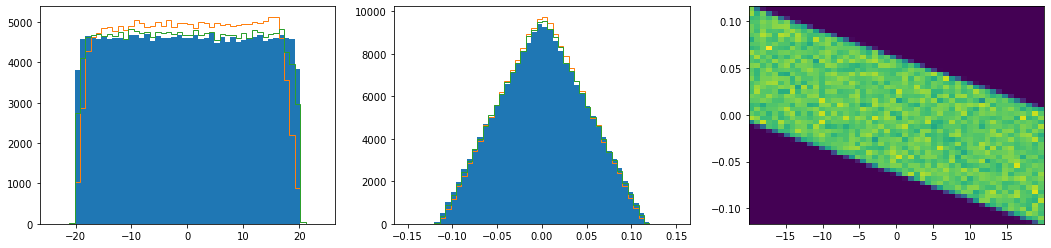

In [41]:
ncols, nrows = (3,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
axs = axs.flatten()

axs[0].hist(data['ev_mu_x'][Y_mu==1], bins=50, range=(-24, 24) )
axs[0].hist(lfits[:,1][Y_mu==1], bins=50, histtype='step', range=(-24, 24) )
axs[0].hist(lfits_mu[:,1][Y_mu==1], bins=50, histtype='step', range=(-24, 24) )

axs[1].hist(data['ev_mu_theta'][Y_mu==1], bins=50, range=(-0.15, 0.15) )
axs[1].hist(lfits[:,0][Y_mu==1], bins=50, histtype='step', range=(-0.15, 0.15) )
axs[1].hist(lfits_mu[:,0][Y_mu==1], bins=50, histtype='step', range=(-0.15, 0.15) )

axs[2].hist2d(data['ev_mu_x'][Y_mu==1], data['ev_mu_theta'][Y_mu==1], bins=(50,50))
plt.show()

## Make plots

Text(0, 0.5, 'auc')

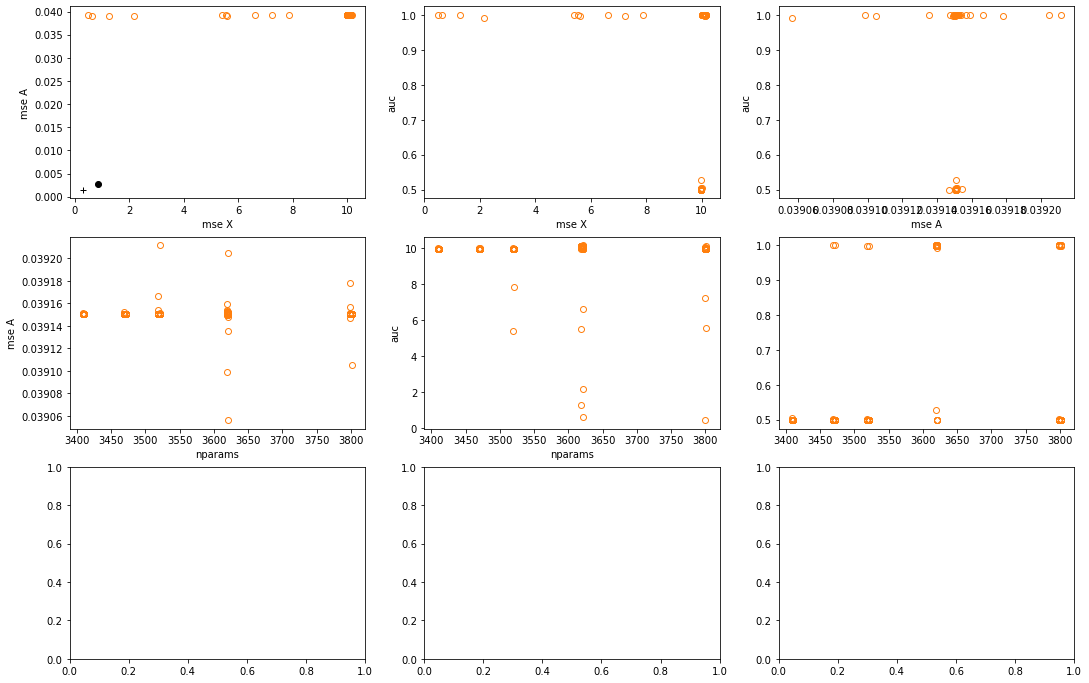

In [135]:
ncols, nrows = (3,3)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
axs = axs.flatten()

this_cut=(Y_mu==1)

chi2_mse_x = metrics.mean_absolute_error( data['ev_mu_x'][this_cut], lfits[this_cut][:,1] )
chi2_mse_a = metrics.mean_absolute_error( data['ev_mu_theta'][this_cut], lfits[this_cut][:,0] )


chi2mu_mse_x = metrics.mean_absolute_error( data['ev_mu_x'][this_cut], lfits_mu[this_cut][:,1] )
chi2mu_mse_a = metrics.mean_absolute_error( data['ev_mu_theta'][this_cut], lfits_mu[this_cut][:,0] )

axs[0].plot(chi2_mse_x, chi2_mse_a, marker='o', color='black')
axs[0].plot(chi2mu_mse_x, chi2mu_mse_a, marker='+', color='black')

archs_c = []
archs_d = []

for mod in mdicts:

    confs = mod['name'].split('_')
    clayers = confs[1]
    dlayers = confs[2]
    CBNorm = 1.0 if 'True' in confs[3] else 0.0
    CBNorm = 1.0 if 'True' in confs[4] else 0.0
    LL = float(confs[5].replace('ll', ''))
    ptype = float(confs[6].replace('ptype', ''))
    penX = 1.0 if 'True' in confs[7] else 0.0
    penA = 1.0 if 'True' in confs[8] else 0.0
    bkgPen = 1.0 if 'True' in confs[9] else 0.0
    regBias = 1.0 if 'True' in confs[10] else 0.0
    
    if clayers not in archs_c: 
        archs_c.append(clayers)
    if dlayers not in archs_d: 
        archs_d.append(dlayers)
    
    indc = archs_c.index(clayers)
    indd = archs_d.index(dlayers)
    
    mod_mse_x = metrics.mean_absolute_error( data['ev_mu_x'][this_cut], mod['x_reg'][this_cut] )
    mod_mse_a = metrics.mean_absolute_error( data['ev_mu_theta'][this_cut], mod['a_reg'][this_cut] )
    mod_auc = metrics.roc_auc_score( Y_mu, mod['yhat'] )
    
    
    axs[0].plot( mod_mse_x, mod_mse_a, marker='o', color=color, fillstyle='none')
    
    axs[1].plot( mod_mse_x, mod_auc, marker='o', color=color, fillstyle='none')
    
    axs[2].plot( mod_mse_a, mod_auc, marker='o', color=color, fillstyle='none')
    
    axs[3].plot( mod['n_params'], mod_mse_a, marker='o', color=color, fillstyle='none')
    axs[4].plot( mod['n_params'], mod_mse_x, marker='o', color=color, fillstyle='none')
    axs[5].plot( mod['n_params'], mod_auc, marker='o', color=color, fillstyle='none')
    
axs[0].set_xlabel('mse X')
axs[0].set_ylabel('mse A')

axs[1].set_xlabel('mse X')
axs[1].set_ylabel('auc')

axs[2].set_xlabel('mse A')
axs[2].set_ylabel('auc')

axs[3].set_xlabel('nparams')
axs[3].set_ylabel('mse A')

axs[4].set_xlabel('nparams')
axs[4].set_ylabel('mse A')

axs[4].set_xlabel('nparams')
axs[4].set_ylabel('auc')

In [136]:
this_cut=(Y_mu==1)

# chi2_mse_x = metrics.mean_absolute_error( data['ev_mu_x'][this_cut], lfits[this_cut][:,1] )
# chi2_mse_a = metrics.mean_absolute_error( data['ev_mu_theta'][this_cut], lfits[this_cut][:,0] )


# chi2mu_mse_x = metrics.mean_absolute_error( data['ev_mu_x'][this_cut], lfits_mu[this_cut][:,1] )
# chi2mu_mse_a = metrics.mean_absolute_error( data['ev_mu_theta'][this_cut], lfits_mu[this_cut][:,0] )

# axs[0].plot(chi2_mse_x, chi2_mse_a, marker='o', color='black')
# axs[0].plot(chi2mu_mse_x, chi2mu_mse_a, marker='+', color='black')

archs_c = []
archs_d = []

ar_ind_c = []
ar_ind_d = []
ar_CBNorm = []
ar_DBNorm = []
ar_LL = []
ar_ptype = []
ar_penX = []
ar_penA = []
ar_bkgPen = []
ar_regBias = []
ar_mse_x = []
ar_mse_a = []
ar_auc = []
ar_npars = []

for mod in mdicts:

    confs = mod['name'].split('_')
    clayers = confs[1]
    dlayers = confs[2]
    CBNorm = 1.0 if 'True' in confs[3] else 0.0
    DBNorm = 1.0 if 'True' in confs[4] else 0.0
    LL = float(confs[5].replace('ll', ''))
    ptype = float(confs[6].replace('ptype', ''))
    penX = 1.0 if 'True' in confs[7] else 0.0
    penA = 1.0 if 'True' in confs[8] else 0.0
    bkgPen = 1.0 if 'True' in confs[9] else 0.0
    regBias = 1.0 if 'True' in confs[10] else 0.0
    
    if clayers not in archs_c: 
        archs_c.append(clayers)
    if dlayers not in archs_d: 
        archs_d.append(dlayers)
    
    indc = archs_c.index(clayers)
    indd = archs_d.index(dlayers)
    
    mod_mse_x = metrics.mean_absolute_error( data['ev_mu_x'][this_cut], mod['x_reg'][this_cut] )
    mod_mse_a = metrics.mean_absolute_error( data['ev_mu_theta'][this_cut], mod['a_reg'][this_cut] )
    mod_auc = metrics.roc_auc_score( Y_mu, mod['yhat'] )
    npars = mod['n_params']
    
    ar_ind_c.append(indc)
    ar_ind_d.append(indd)
    ar_CBNorm.append(CBNorm)
    ar_DBNorm.append(DBNorm)
    ar_LL.append(LL)
    ar_ptype.append(ptype)
    ar_penX.append(penX)
    ar_penA.append(penA)
    ar_bkgPen.append(bkgPen)
    ar_regBias.append(regBias)
    ar_mse_x.append(mod_mse_x)
    ar_mse_a.append(mod_mse_a)
    ar_auc.append(mod_auc)
    ar_npars.append(npars)
    

all_ars = []
all_ars.append( ar_ind_c )
all_ars.append( ar_ind_d )
all_ars.append( ar_CBNorm )
all_ars.append( ar_DBNorm )
# all_ars.append( ar_LL )
all_ars.append( ar_ptype )
all_ars.append( ar_penX )
all_ars.append( ar_penA )
all_ars.append( ar_bkgPen )
all_ars.append( ar_regBias )
# all_ars.append( ar_npars )
all_ars.append( ar_mse_x )
all_ars.append( ar_mse_a )
all_ars.append( ar_auc )



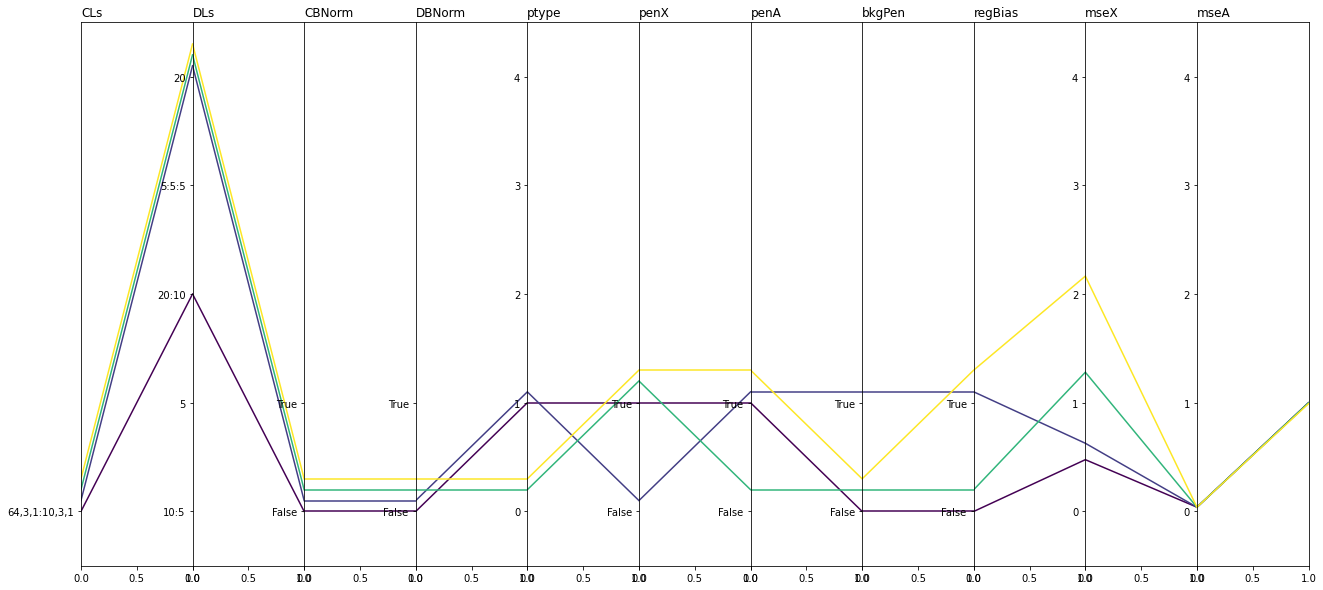

In [158]:
ars_names = [
'CLs',
'DLs',
'CBNorm',
'DBNorm',
# 'LL', 
'ptype',
'penX',
'penA', 
'bkgPen', 
'regBias', 
# 'npars',
'mseX',
'mseA', 
'auc'
]

ncols, nrows = (len(all_ars)-1,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(2*ncols,10*nrows), sharey=False)
axs = axs.flatten()
    
this_mod = 0
max_msex = 4
max_max_msex = np.log( np.array(ar_mse_x)[np.array(ar_mse_x)<max_msex].max() )
min_max_msex = np.log( np.array(ar_mse_x)[np.array(ar_mse_x)<max_msex].min() )

for imod,mod in enumerate(mdicts):
    
    if ar_mse_x[imod] > max_msex: continue
    
    col_x = (np.log( ar_mse_x[imod] ) - min_max_msex)/(max_max_msex - min_max_msex)
    
    for iar in range(len(all_ars) - 1):
        
        if 'regBias' in ars_names[iar]:
            ysets = [all_ars[iar][imod] + this_mod*0.1, all_ars[iar+1][imod]]
        elif 'mse' in ars_names[iar] or 'auc' in ars_names[iar]:
            ysets = [all_ars[iar][imod], all_ars[iar+1][imod]]
        else:
            ysets = [all_ars[iar][imod] + this_mod*0.1, all_ars[iar+1][imod] + this_mod*0.1]
        
        axs[iar].plot( [0, 1], ysets, color=plt.cm.viridis(col_x) )
        axs[iar].set_title(ars_names[iar], loc='left')
    
    this_mod += 1
        

for iax,ax in enumerate(axs):
    ax.set_ylim(-0.5, max_msex + 0.5)
    ax.set_xlim(0,1)
    if iax == 0:
        ax.set_yticks( range(len(archs_c)) )
        ax.set_yticklabels( archs_c )
    if iax == 1:
        ax.set_yticks( range(len(archs_d)) )
        ax.set_yticklabels( archs_d )
    if iax == 2 or iax == 3 or iax == 5 or iax == 6 or iax == 7 or iax == 8:
        ax.set_yticks( [0,1] )
        ax.set_yticklabels( ['False', 'True'] )
    
plt.subplots_adjust(wspace=0)
plt.show()